<a href="https://colab.research.google.com/github/Ying-Yuan07/TensorFlowLearn/blob/main/LSTM%E5%8F%98%E9%87%8F4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(35, 2)
train
[[   0.  -120.1]
 [-120.1   37.2]
 [  37.2  -63.8]
 [ -63.8   61. ]
 [  61.   -11.8]
 [ -11.8   63.3]
 [  63.3   -7.3]
 [  -7.3  -31.7]
 [ -31.7  -69.9]
 [ -69.9  213.6]
 [ 213.6 -150.6]
 [-150.6    8.4]
 [   8.4  -44.8]
 [ -44.8   60.6]
 [  60.6   63.2]
 [  63.2  -81.9]
 [ -81.9   95.6]
 [  95.6  -61. ]
 [ -61.    77.6]
 [  77.6  -13.7]
 [ -13.7  131.7]
 [ 131.7 -157.1]
 [-157.1   77.8]]
train_scaled
[[-0.15241435 -0.80037766]
 [-0.80037766  0.04828702]
 [ 0.04828702 -0.496628  ]
 [-0.496628    0.17669274]
 [ 0.17669274 -0.21607769]
 [-0.21607769  0.1891017 ]
 [ 0.1891017  -0.1917993 ]
 [-0.1917993  -0.32344214]
 [-0.32344214 -0.52953871]
 [-0.52953871  1.        ]
 [ 1.         -0.96493121]
 [-0.96493121 -0.10709469]
 [-0.10709469 -0.39411923]
 [-0.39411923  0.17453466]
 [ 0.17453466  0.18856218]
 [ 0.18856218 -0.59428109]
 [-0.59428109  0.3633666 ]
 [ 0.3633666  -0.48152145]
 [-0.48152145  0.26625303]
 [ 0.26625303 -0.22632857]
 [-0.22632857  0.55813326]
 [ 0.55813326 

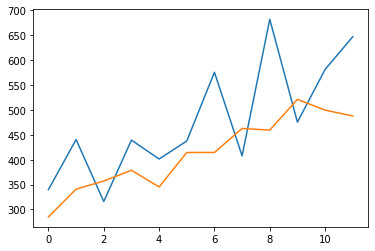

In [10]:
# coding=utf-8
from pandas import read_csv
from pandas import datetime
from pandas import concat
from pandas import DataFrame
from pandas import Series
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


# 读取时间数据的格式化
def parser(x):
    return datetime.strptime(x, '%Y/%m/%d')


# 转换成有监督数据
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]  # 数据滑动一格，作为input，df原数据为output
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


# 转换成差分数据
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# 逆差分
def inverse_difference(history, yhat, interval=1):  # 历史数据，预测数据，差分间隔
    return yhat + history[-interval]


# 缩放
def scale(train, test):
    # 根据训练数据建立缩放器
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # 转换train data
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # 转换test data
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


# 逆缩放
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


# fit LSTM来训练数据
def fit_lstm(train, batch_size, nb_epoch, neurons):#fit_lstm(train_scaled, 1, 100, 4)
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])#X.reshape(X.shape[0], 1, 1)
    model = Sequential()
    # 添加LSTM层
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))  # 输出层1个node
    # 编译，损失函数mse+优化算法adam
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        # 按照batch_size，一次读取batch_size个数据
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        print("当前计算次数："+str(i))
    return model

# 1步长预测
def forcast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]


# 加载数据
series = read_csv('./sample_data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,
                  date_parser=parser)

# 让数据变成稳定的
raw_values = series.values
diff_values = difference(raw_values, 1)#转换成差分数据
# 把稳定的数据变成有监督数据
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print(supervised_values.shape)
# 数据拆分：训练数据、测试数据，前24行是训练集，后12行是测试集
train, test = supervised_values[0:-12], supervised_values[-12:]
# 数据缩放
scaler, train_scaled, test_scaled = scale(train, test)
# fit 模型
lstm_model = fit_lstm(train_scaled, 1, 100, 4)  # 训练数据，batch_size，epoche次数, 神经元个数
# 预测
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)#训练数据集转换为可输入的矩阵
lstm_model.predict(train_reshaped, batch_size=1)#用模型对训练数据矩阵进行预测

# 测试数据的前向验证，实验发现，如果训练次数很少的话，模型回简单的把数据后移，以昨天的数据作为今天的预测值，当训练次数足够多的时候
# 才会体现出来训练结果
predictions = list()
for i in range(len(test_scaled)):#根据测试数据进行预测，取测试数据的一个数值作为输入，计算出下一个预测值，以此类推
    # 1步长预测
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forcast_lstm(lstm_model, 1, X)
    # 逆缩放
    yhat = invert_scale(scaler, X, yhat)
    # 逆差分
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Moth=%d, Predicted=%f, Expected=%f' % (i + 1, yhat, expected))

# 性能报告
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE:%.3f' % rmse)
# 绘图
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()